In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, plot_violin, accuracy_perumtations, 
    plot_thresh_to_acc, age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test, deconfound,
)

/tmp/ipykernel_4567/1876315637.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Mon Feb  6 13:11:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:85:00.0 Off |                  N/A |
| 47%   85C    P2   216W / 250W |   2555MiB / 12288MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# TODO: 
# mail denis
# mail joschka
# check offdiagonal age sources gap
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?
# accept a thresh as input (valid for eval)

In [4]:
#work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/jovyan/'
#work_dir = '/home/lukas/Code/brain_age/'

In [5]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence, cv
#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval

#exp = '2023-02-03T16:48:50.460303' # TCN exluding recs with age divergence, subject-wise cv
exp = '2023-02-03T22:27:26.056071' # TCN exluding recs with age divergence, subject-wise fe

#exp = '2023-02-05T18:24:08.295474'

exp_dir = os.path.join(base_dir, exp)

In [6]:
configs = read_result(exp_dir, 'config')

In [7]:
configs

,augment,batch_size,data_path,date,debug,fast_mode,final_eval,intuitive_training_scores,loss,max_age,...,squash_outs,standardize_data,standardize_targets,subset,target_name,tmin,tmax,valid_set_i,window_size_samples,run_name
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-03T22:27:26.056071,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
1,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-03T22:27:26.056071,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,1,6000,decode_age
2,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-03T22:27:26.056071,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,2,6000,decode_age
3,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-03T22:27:26.056071,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,3,6000,decode_age
4,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-03T22:27:26.056071,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,4,6000,decode_age


In [8]:
assert configs['final_eval'].nunique() == 1

In [9]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed']]

,model_name,target_name,valid_set_i,seed
0,tcn,age,0,20230203
1,tcn,age,1,20230203
2,tcn,age,2,20230203
3,tcn,age,3,20230203
4,tcn,age,4,20230203


In [10]:
scores = read_result(exp_dir, 'score')

In [11]:
if (configs['final_eval'] == '1').all():
    display(scores.loc[['mae']].mean())
else:
    display(scores.loc[['mae']].groupby('seed').mean())

train               2.321002e+00
eval                6.522669e+00
valid_not_normal    1.368418e+01
seed                2.023020e+07
valid_set_i         2.000000e+00
transition          3.997051e+00
dtype: float64

In [12]:
histories = read_result(exp_dir, 'history')

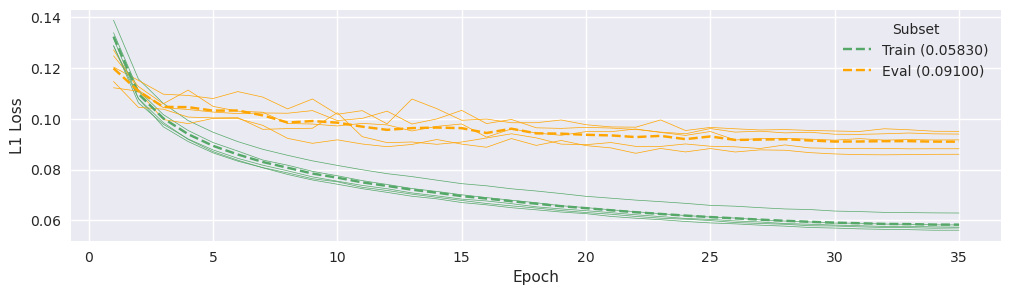

In [13]:
if (configs['final_eval'] == '1').all():
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], 'L1 Loss', 'Eval')
    ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], 'L1 Loss')
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')

In [14]:
preds = read_result(exp_dir, 'preds')

In [15]:
accs = []
for n1, g1 in preds.groupby('seed'):
    acc = balanced_accuracy_score(g1.y_true.to_numpy().astype(int), g1.y_pred.to_numpy().astype(int))
    accs.append(acc)
mean_acc = np.mean(accs)
print(f'avg acc over {preds.seed.nunique()} seeds with {preds.valid_set_i.nunique()} folds', mean_acc)

avg acc over 1 seeds with 5 folds 0.039851687540567


TODO: automatically find y_lim  
TODO: always plot subject_wise?

In [16]:
def heatmaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)]
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
        g1 = deconfound(g1, detrend)
        ax = plot_heatmaps(g1, bin_width, 100, 12)
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = g1[g1.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            g1 = deconfound(g1, detrend)
            ax = plot_heatmaps(g1, bin_width, 100, 100)
    return ax

In [17]:
def gaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
        g1 = deconfound(g1, detrend)
        ax = plot_age_gap_hist_and_permutation_test(
            g1, bin_width, n_repetitions,
        )
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = preds[preds.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            g1 = deconfound(g1, detrend)
            ax = plot_age_gap_hist_and_permutation_test(
                g1, bin_width, n_repetitions,
            )
    return ax

In [31]:
def proxy(preds, configs, sex, min_age, max_age, cols, detrend, bin_width, thresh1=None, thresh2=None):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
        g1 = deconfound(g1, detrend)
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            g1, bin_width, n_repetitions, thresh1, thresh2,
        )
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = preds[preds.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            g1 = deconfound(g1, detrend)
            ax = plot_age_gap_hist_with_thresh_and_permutation_test(
                g1, bin_width, n_repetitions,
            )
    return ax

Mon Feb  6 13:13:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:85:00.0 Off |                  N/A |
| 50%   81C    P2   105W / 250W |   2555MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
bin_width = 2
n_repetitions = 1000  # ! actually 100000 !
cols = ['y_pred', 'y_true', 'pathological', 'subject', 'index', 'subset']

In [37]:
if n_repetitions != 100000:
    print("WARNING! Wrong number of reps!")

WARNING! Wrong number of reps!


In [38]:
save = False
age_limits = [(None, None)]  #[(None, 30), (30, 60), (60, None)]
sexes = [None]#['F', 'M']
detrends = ['quadratic']  # None, linear, quadratic
# extracted from cv
thresh1 = -10.714303716473694 if (configs['final_eval'] == '1').all() else None 
thresh2 = 6.654044931499072 if (configs['final_eval'] == '1').all() else None
#thresh1 = None
#thresh2 = None

17 91 None quadratic -10.714303716473694 6.654044931499072
observed age gap diff 0.85773314706551
given thresholds -10.714303716473694 6.654044931499072
observed score 61.25987708516243


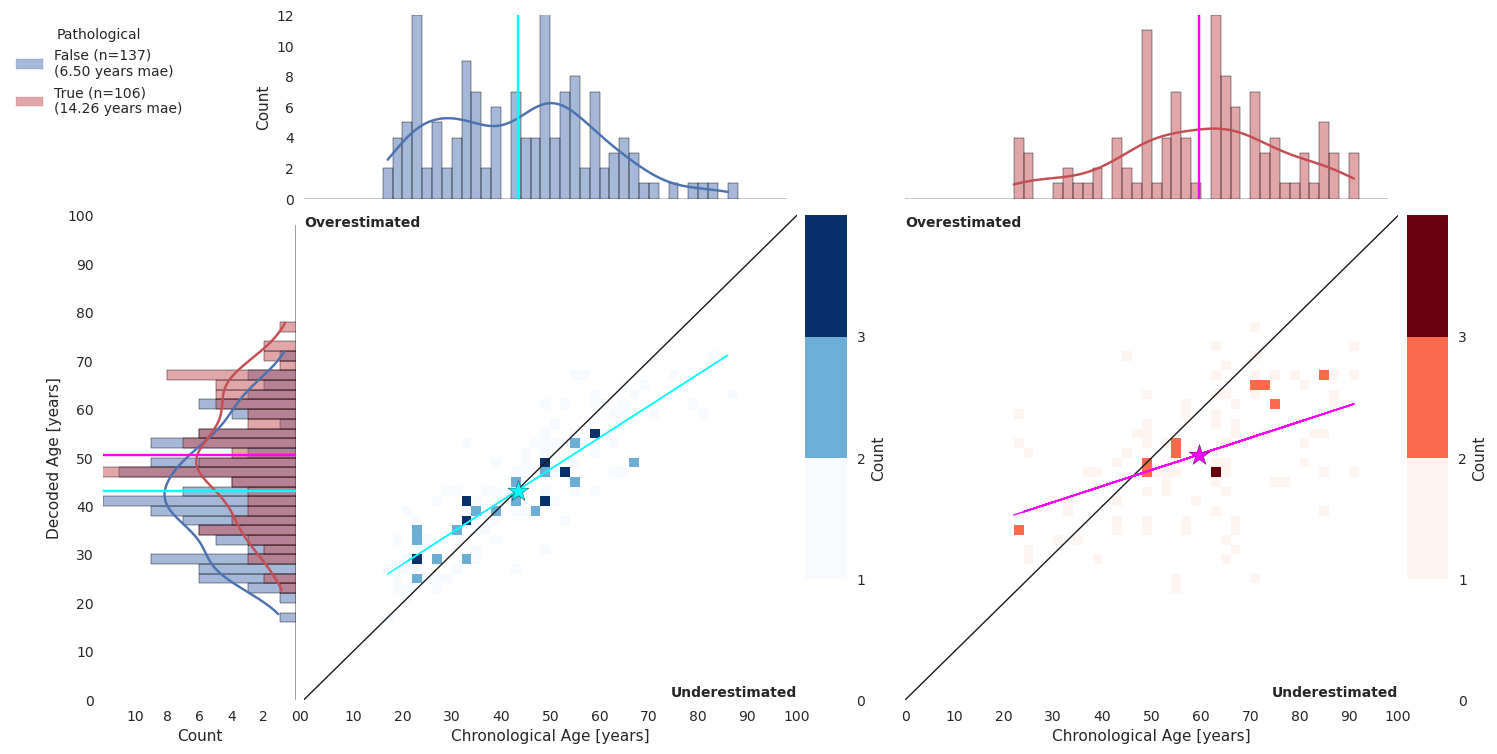

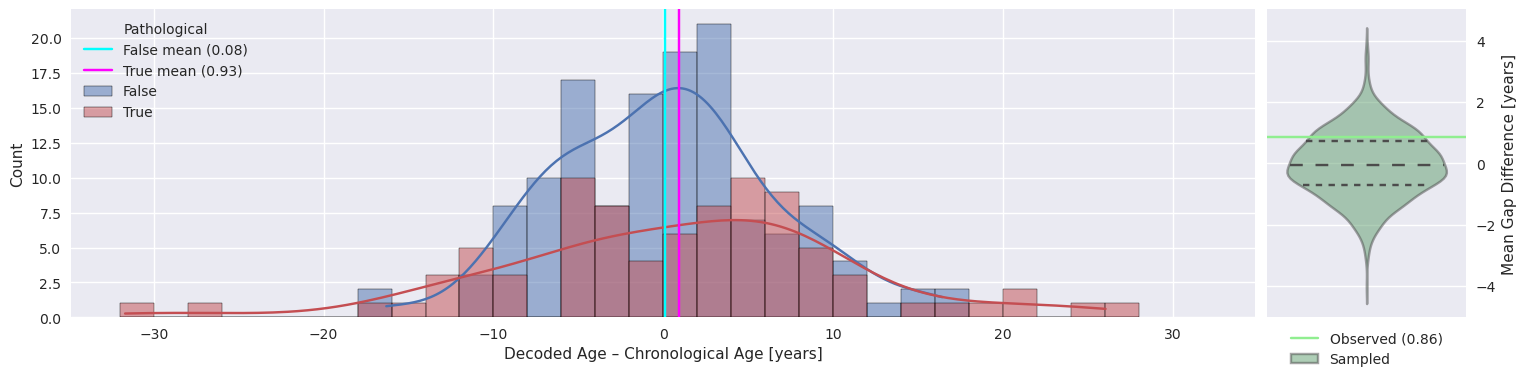

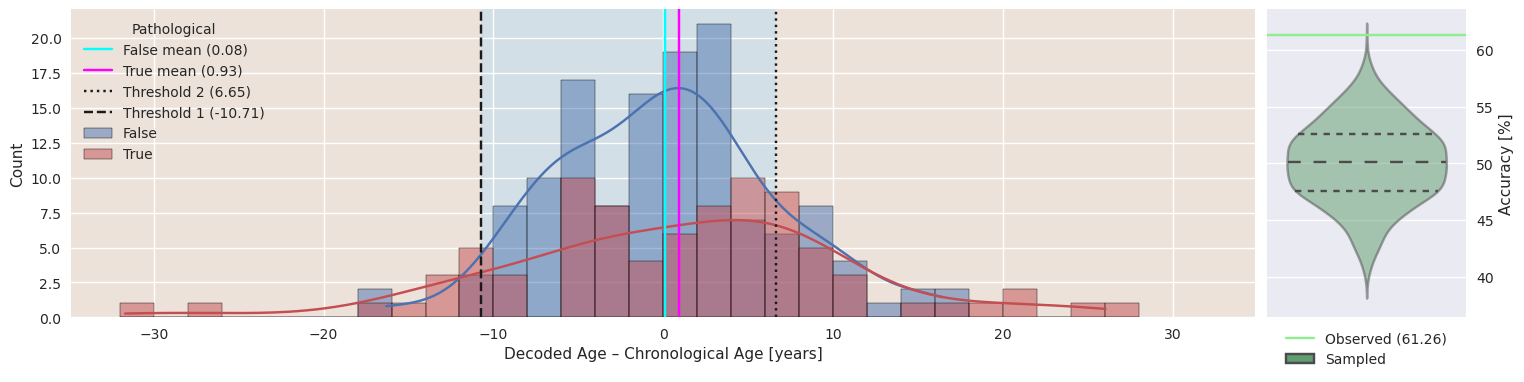

In [39]:
for (min_age, max_age) in age_limits:
    for sex in sexes:
        for detrend in detrends:
            max_age = preds.age.max() if max_age is None else max_age
            min_age = preds.age.min() if min_age is None else min_age
            print(min_age, max_age, sex, detrend, thresh1, thresh2)
            # actual predictions can never be detrended as this would be cheating
            ax = heatmaps(preds, configs, sex, min_age, max_age, cols, None, bin_width)
            if save:
                ax.get_figure().savefig('/home/jovyan/eval_heatmaps.jpg', bbox_inches='tight', dpi=300)
            ax = gaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width)
            if save:
                ax.get_figure().savefig('/home/jovyan/eval_gaps.jpg', bbox_inches='tight', dpi=300)
            ax = proxy(preds, configs, sex, min_age, max_age, cols, detrend, bin_width, thresh1, thresh2)
            if save:
                ax.get_figure().savefig('/home/jovyan/eval_proxy.jpg', bbox_inches='tight', dpi=300)